In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import sys; sys.path.append(2*'../')
from src import *
import matplotlib.pyplot as plt
from torch import cos, sin, sign, norm

# device = torch.device('cuda:0')
device=torch.device('cpu')

import matplotlib.pyplot as plt


In [2]:
# print(max(torch.load('data/trajectory_rk4.pt')[:, 8]))
# experiments = ['hypereuler', 'euler', 'midpoint', 'rk4']
colors = {'euler': 'tab:red', 'hypereuler': 'tab:orange', 'midpoint':'tab:green', 'rk4': 'tab:purple'}
labels = {'euler': 'Euler', 'hypereuler': 'HyperEuler', 'midpoint':'Midpoint', 'rk4': 'RK4'}

In [89]:
experiments = ['hypereuler', 'euler', 'midpoint', 'rk4']
num = 30 # change this

trajectories_he, controls_he, losses_he = [], [], []
trajectories_eu, controls_eu, losses_eu = [], [], []
trajectories_mp, controls_mp, losses_mp = [], [], []
trajectories_rk, controls_rk, losses_rk = [], [], []

for n in range(num):
    name = experiments[0] + '_' + str(n) + ".pt"
    trajectories_he.append(torch.load('data/trajectory_'+name))
    controls_he.append(torch.load('data/controls_'+name))        

for n in range(num):
    name = experiments[1] + '_' + str(n) + ".pt"
    trajectories_eu.append(torch.load('data/trajectory_'+name))
    controls_eu.append(torch.load('data/controls_'+name))        

for n in range(num):
    name = experiments[2] + '_' + str(n) + ".pt"
    trajectories_mp.append(torch.load('data/trajectory_'+name))
    controls_mp.append(torch.load('data/controls_'+name))        

for n in range(num):
    name = experiments[3] + '_' + str(n) + ".pt"
    trajectories_rk.append(torch.load('data/trajectory_'+name))
    controls_rk.append(torch.load('data/controls_'+name))        



# print(torch.load('data/losses_rk4_5.pt'))

In [90]:
target = 8*torch.Tensor([1, 1, 1])
from statistics import mean, stdev

def target_distance(traj, target=target):
    return torch.norm(traj[-1, :3] - target)

err_eu = []
for t in trajectories_eu:
    # print(target_distance(t))
    err_eu.append(target_distance(t).item())
print('Euler mean +- std:', mean(err_eu), stdev(err_eu))

err_he = []
for t in trajectories_he:
    # print(target_distance(t))
    err_he.append(target_distance(t).item())

print('HyperEuler mean +- std:', mean(err_he), stdev(err_he))


err_mp = []
for t in trajectories_mp:
    # print(target_distance(t))
    err_mp.append(target_distance(t).item())
print('Midpoint mean +- std:', (mean(err_mp)), stdev(err_mp))

err_rk = []
for t in trajectories_rk:
    # print(target_distance(t))
    err_rk.append(target_distance(t).item())

print('RK4 mean +- std:', mean(err_rk), stdev(err_rk))

Euler mean +- std: 1.0964055816332499 0.37499921382382184
HyperEuler mean +- std: 0.6621467630068462 0.23746827125175263
Midpoint mean +- std: 0.711106875538826 0.16768080347516864
RK4 mean +- std: 0.7091924160718918 0.19952707422885904


## Plot positions errors boxplot

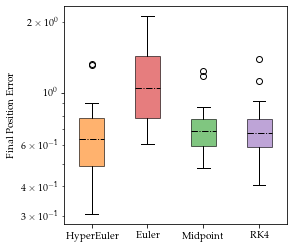

In [103]:
colors = [ 'tab:orange', 'tab:red', 'tab:green', 'tab:purple']
labels = [ 'HyperEuler','Euler', 'Midpoint', 'RK4']


fig, ax = plt.subplots(1,1, figsize=(4,4))

bp = ax.boxplot([err_he, err_eu, err_mp, err_rk],
                patch_artist=True, labels=labels)
for b, m, c in zip(bp['boxes'], bp['medians'], colors):
    b.set_facecolor(c)
    b.set_alpha(0.6)
    m.set(color='black', linestyle='-.')
ax.set_yscale('log')
# ax.set_ylim(0, 0.02)
# ax.set_title('Quadcopter residuals distribution')
ax.set_ylabel('Final Position Error')

# ## Saving
import tikzplotlib
fig.savefig('media/quadcopter_control_errors.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/quadcopter_control_errors.tex")

In [95]:
experiments = ['hypereuler', 'euler', 'midpoint', 'rk4']
colors = {'euler': 'tab:red', 'hypereuler': 'tab:orange', 'midpoint':'tab:green', 'rk4': 'tab:purple'}
labels = {'euler': 'Euler', 'hypereuler': 'HyperEuler', 'midpoint':'Midpoint', 'rk4': 'RK4'}

Text(0.5, 0.92, 'Trajectories')

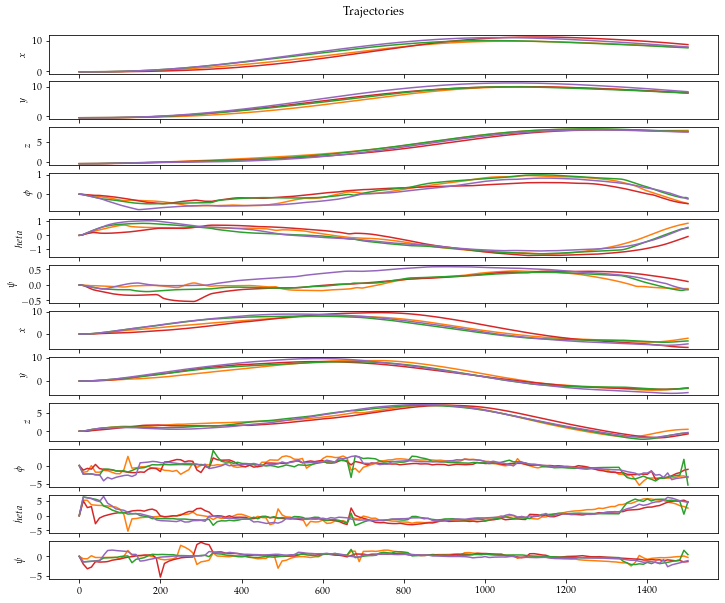

In [96]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(12, 1, figsize=(12, 10))

axis_labels = ['$x$', '$y$', '$z$', '$\phi$', '$\theta$', '$\psi$', '$\dot x$', '$\dot y$', '$\dot z$', '$\dot \phi$', '$\dot \theta$', '$\dot \psi$']
trajectories = (trajectories_he, trajectories_eu, trajectories_mp, trajectories_rk)
for exp, traj in zip(experiments, trajectories):
    traj = traj[19]
    for ax, i, axis_label in zip(axs, range(len(axs)), axis_labels):
        ax.plot(traj[:, i].cpu().detach(), color=colors[exp])
        ax.label_outer()
        ax.set_ylabel(axis_label)

fig.suptitle('Trajectories', y=0.92, fontweight='bold')  

In [97]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [98]:
# MPC trajectory: plot every 0.02s 
num = 19 # trajectory number
skip = 20 # we skip 20 frams at a time
trajs_reduced = []
for tr in trajectories:
    t = []
    for i in range(int(tr[num].shape[0]/skip)):
        t.append(tr[num][i*skip,:][None])
    tr = np.concatenate(t)
    trajs_reduced.append(tr)

t_span = torch.linspace(0, 3, trajs_reduced[0].shape[0])

In [99]:
# Plotting utils
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import HTML

def cuboid_data2(pos, size=(1,1,1), rotation=None):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    if rotation is not None:
        for i in range(4):
            X[:,i,:] = np.dot(rotation, X[:,i,:].T).T
    X += pos
    return X

def plot_cube(position,size=None,rotation=None,color=None, **kwargs):
    if not isinstance(color,(list,np.ndarray)): color=["C0"]*len(position)
    if not isinstance(size,(list,np.ndarray)): size=[(1,1,1)]*len(position)
    g = cuboid_data2(position, size=size, rotation=rotation)
    return Poly3DCollection(g,  
                            facecolor=np.repeat(color,6), **kwargs)

drone_size = [dxm/2, dym/2, dzm]
drone_color = ["royalblue"]


## Plot trajectories

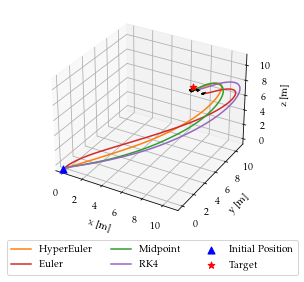

In [102]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

lim = [-0.5, target[2]*1.4]
print('Warning: limits of the plot set to min:', lim[0],' max:', lim[1])
ax.set_xlim3d(lim[0], lim[1])
ax.set_ylim3d(lim[0], lim[1])
ax.set_zlim3d(lim[0], lim[1])
# ax.set_xlabel(r'$x~[m]$')
# ax.set_ylabel(r'$y~[m]$')
# ax.set_zlabel(r'$z~[m]$')

s = 50
scale = 1 # for visualization purposes
s_drone = scale*20 # drone body dimension
dxm = scale*0.16      # arm length (m)
dym = scale*0.16      # arm length (m)
dzm = scale*0.05      # motor height (m)
lw = scale*2
lines1, lines2 = [], []
for e in range(len(experiments)):
    l1, = ax.plot([], [], [], lw=lw, color='black')
    l2, = ax.plot([], [], [], lw=lw, color='grey')
    lines1.append(l1); lines2.append(l2)

body, = ax.plot([], [], [], marker='o', markersize=s_drone, color='black', markerfacecolor='grey')

initial = trajs_reduced[0][0]


init = ax.scatter(initial[0], initial[1], initial[2], marker='^', color='blue', label='Initial Position', s=s)
fin = ax.scatter(target[0], target[1], target[2], marker='*', color='red', label='Target', s=s) # set linestyle to none

num = 1 # select only first
num = 4 # select all

for tr, exp, line1, line, n in zip(trajs_reduced, experiments, lines1, lines2, range(num)):
    # if j >0:
    #     continue
    # j +=1

    ax.plot(tr[:i, 0], tr[:i, 1], tr[:i, 2], color=colors[exp], alpha=1, linestyle='-', label=labels[exp])
    time = t_span[i]
    pos = tr[i]
    x = pos[0]
    y = pos[1]
    z = pos[2]

    x_from0 = tr[0:i,0]
    y_from0 = tr[0:i,1]
    z_from0 = tr[0:i,2]
    # ax.scatter(tr[-1, 0], tr[-1, 1], tr[-1, 2], color=colors[exp], marker = 'o')

    # Trick to reuse the same function
    R = euler_matrix(torch.Tensor([pos[3]]), torch.Tensor([pos[4]]), torch.Tensor([pos[5]])).numpy().squeeze(0)
    motorPoints = np.array([[dxm, -dym, dzm], [0, 0, 0], [dxm, dym, dzm], [-dxm, dym, dzm], [0, 0, 0], [-dxm, -dym, dzm],  [-dxm, -dym, -dzm]])
    motorPoints = np.dot(R, np.transpose(motorPoints))
    motorPoints[0,:] += x 
    motorPoints[1,:] += y 
    motorPoints[2,:] += z

    # Motors
    line1.set_data(motorPoints[0,0:3], motorPoints[1,0:3])
    line1.set_3d_properties(motorPoints[2,0:3])
    line2.set_data(motorPoints[0,3:6], motorPoints[1,3:6])
    line2.set_3d_properties(motorPoints[2,3:6])

    # Body
    pos = ((motorPoints[:, 6] + 2*motorPoints[:, 1])/3)
    body = plot_cube(pos, drone_size, rotation=R, color=[colors[exp]], edgecolor="k")
    ax.add_collection3d(body)

# ax.set_title(u"Quadcopter Trajectory, t = {:.2f} s".format(time))
ax.legend()
ax.set_xlabel(f'x~[m]')
ax.set_ylabel(f'y~[m]')
ax.set_zlabel(f'z~[m]')

ax.legend(loc='upper center', bbox_to_anchor=(0.52, -0.05),
          fancybox=True, shadow=False, ncol=3)


# ## Saving
import tikzplotlib
fig.savefig('media/quadcopter_race.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/quadcopter_race.tex")

## Plot simulation `.gif`


MovieWriter imagemagick unavailable; using Pillow instead.


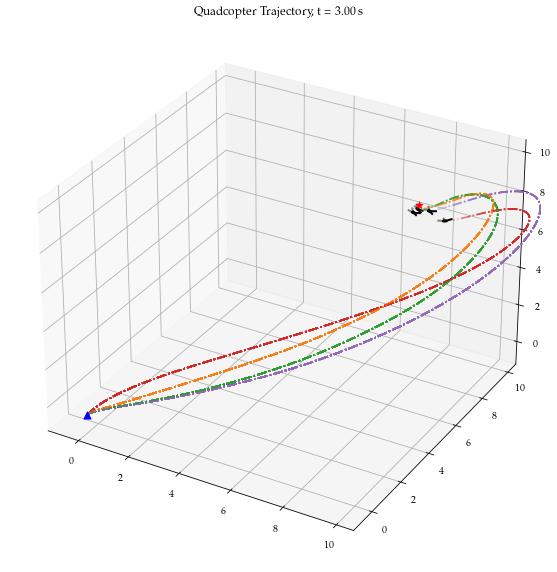

In [47]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

lim = [-1, target[2]*1.3]
print('Warning: limits of the plot set to min:', lim[0],' max:', lim[1])
ax.set_xlim3d(lim[0], lim[1])
ax.set_ylim3d(lim[0], lim[1])
ax.set_zlim3d(lim[0], lim[1])
# ax.set_xlabel(r'$x~[m]$')
# ax.set_ylabel(r'$y~[m]$')
# ax.set_zlabel(r'$z~[m]$')

s = 50
s_drone = 20 # drone body dimension
dxm = 0.16      # arm length (m)
dym = 0.16      # arm length (m)
dzm = 0.05      # motor height (m)

lines1, lines2 = [], []
for e in range(len(experiments)):
    l1, = ax.plot([], [], [], lw=2, color='black')
    l2, = ax.plot([], [], [], lw=2, color='black')
    lines1.append(l1); lines2.append(l2)

body, = ax.plot([], [], [], marker='o', markersize=s_drone, color='black', markerfacecolor='black')

initial = trajs_reduced[0][0]

def get_frame(i):
#     if i != 0: del ax.collections[:] # remove elements 
    del ax.collections[:] # remove previous 3D elements 
    init = ax.scatter(initial[0], initial[1], initial[2], marker='^', color='blue', label='Initial Position', s=s)
    fin = ax.scatter(target[0], target[1], target[2], marker='*', color='red', label='Target', s=s) # set linestyle to none
    
    for tr, exp, line1, line2 in zip(trajs_reduced, experiments, lines1, lines2):
        ax.plot(tr[:i, 0], tr[:i, 1], tr[:i, 2], color=colors[exp], alpha=0.2, linestyle='-.')
        time = t_span[i]
        pos = tr[i]
        x = pos[0]
        y = pos[1]
        z = pos[2]

        x_from0 = tr[0:i,0]
        y_from0 = tr[0:i,1]
        z_from0 = tr[0:i,2]

        # Trick to reuse the same function
        R = euler_matrix(torch.Tensor([pos[3]]), torch.Tensor([pos[4]]), torch.Tensor([pos[5]])).numpy().squeeze(0)
        motorPoints = np.array([[dxm, -dym, dzm], [0, 0, 0], [dxm, dym, dzm], [-dxm, dym, dzm], [0, 0, 0], [-dxm, -dym, dzm],  [-dxm, -dym, -dzm]])
        motorPoints = np.dot(R, np.transpose(motorPoints))
        motorPoints[0,:] += x 
        motorPoints[1,:] += y 
        motorPoints[2,:] += z

        # Motors
        line1.set_data(motorPoints[0,0:3], motorPoints[1,0:3])
        line1.set_3d_properties(motorPoints[2,0:3])
        line2.set_data(motorPoints[0,3:6], motorPoints[1,3:6])
        line2.set_3d_properties(motorPoints[2,3:6])

        # Body
        pos = ((motorPoints[:, 6] + 2*motorPoints[:, 1])/3)
        body = plot_cube(pos, drone_size, rotation=R, color=[colors[exp]], edgecolor="k")
        ax.add_collection3d(body)
    
    ax.set_title(u"Quadcopter Trajectory, t = {:.2f} s".format(time))
    
def anim_callback(i, get_world_frame):
    frame = get_world_frame(i)
    set_frame(frame)
    
def set_frame(frame):
    # convert 3x6 world_frame matrix into three line_data objects which is 3x2 (row:point index, column:x,y,z)
    lines_data = [frame[:,[0,2]], frame[:,[1,3]], frame[:,[4,5]]]
    ax = plt.gca()
    lines = ax.get_lines()
    for line, line_data in zip(lines[:3], lines_data):
        x, y, z = line_data
        line.set_data(x, y)
        line.set_3d_properties(z)
        
from matplotlib.animation import FuncAnimation

an = FuncAnimation(fig,
                     get_frame,
                     init_func=None,
                     frames=len(t_span), interval=20, blit=False)

an.save('media/simulation.gif', dpi=80, writer='imagemagick', fps=60)

HTML(an.to_html5_video())